### Problem 3: 

Here, we are to implement example 6.6 from the book Sutton and Barto. The environment is similar to the gridworld problem but now it is a 4 x 12 grid with start state as (4,1) and goal state as (4,12). The states (4,2) to (4,11) are cliffs. Every transition but the transitions to a cliff state yields a reward of -1. If a transition happens to a cliff state, we get a reward of -100 and we go back to the start state. We compare the performance of Q-Learning and SARSA algorithms in such an environment.

In [1]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [2]:
#building the environment
class Cliff_Environment:
    def __init__(self, M,N, holes, start_state, goal_state): #initializing the environment states, holes, terminals and rewards
        self.states = set()
        self.start_state = start_state
        self.grid_shape = (M,N)
        self.holes = holes
        self.terminal_state = goal_state
        
        for i in range(1,M+1):
            for j in range(1, N+1):
                if (i,j) not in holes:
                    self.states.add((i,j))
                    
        self.rewards = self.initialize_rewards()
    
    def initialize_rewards(self): #function to initialize the rewards for each state of the environment
        r = {}
        for state in self.states:
            if state in self.holes:
                r[state] = -100
            else:
                r[state] = -1
                
        return r
    
    def agent_move(self, s, a): #function to update the state of the agent given an action a and current state s
        x, y = s
        if a=='U':
            x = x-1
        elif a=='D':
            x = x + 1
        elif a=='R':
            y = y + 1
        elif a=='L':
            y = y - 1
            
        stay_same = self.check_corner((x,y))

        if stay_same:
            return s

        return (x,y)

    def move_clockwise90(self, a): #function to return the action which is a 90 degree rotation to current action a
        if a=='U':
            return 'R'
        elif a=='R':
            return 'D'
        elif a=='D':
            return 'L'
        elif a=='L':
            return 'U'
        
    def move_anti_clockwise90(self, a): #function to return the action which is a 90 degree rotation to current action a
        if a=='U':
            return 'L'
        elif a=='L':
            return 'D'
        elif a=='D':
            return 'R'
        elif a=='R':
            return 'U'   
    
    def check_corner(self, s): 
        #function to check if the updates state goes out of the gridworld. 
        #If so, it returns a True value to address that the update should not take place and agent should remain in current state. 
        
        x1, y1 = s
        stay_same = False

        if x1<1 or x1>self.grid_shape[0]:
            stay_same = True
        if y1<1 or y1>self.grid_shape[1]:
            stay_same = True
        
        return stay_same
    
    def get_s_r(self, s_new):
        #function to return the new state and reward 
        if s_new in env.holes:
            r = -100
            s_new = env.start_state
        else:
            r = -1
    
        return (s_new,r)
        
    def get_new_state(self, s, a): 
        #this is the function to take the agent to an update state given the agent's choice of action and current state.
        #This encapsulates the dynamics of the environment and is not known to the agent. The agent only
        #produces the current state s and his choice of action a, to which the environment returns his new state s1.
        x, y = s
        #t = random.random()
        
        s_new = self.agent_move(s,a)
        if s_new in env.holes:
            r = -100
            s_new = env.start_state
        else:
            r = -1
    
        return (s_new,r)
        
        '''if t<=0.8: #agent's action succeeds
            s_new = self.agent_move(s,a)
        
        
        elif 0.8<t<=0.9:
            #agent stays in same state
            s_new = s        
        
        elif 0.9<t<=0.95: #move in a 90 degree clockwise direction
            a1 = self.move_clockwise90(a)
            s_new = self.agent_move(s, a1)
        else: #move in a -90 degree clockwise direction
            a1 = self.move_anti_clockwise90(a)
            s_new = self.agent_move(s, a1)
            
        
        s_new, r = self.get_s_r(s_new)'''
        #return (s_new, r)
            

In [3]:
M = 4
N = 12
holes = []
for i in range(2, N):
    holes.append((4,i))
    
env = Cliff_Environment(M = M,N = N, holes = holes, start_state = (4,1) , goal_state = (4,12))

In [11]:
#building the SARSA Agent
class SARSA_Agent:
    def __init__(self, alpha, gamma, epsilon, env):
        #initializing the parameters of the agent
        self.actions = ['L','R','U','D'] #possible actions
        self.gamma = gamma #discount parameter
        self.Q = self.initialize_value_states(env)
        self.alpha = alpha
        self.initial_epsilon = epsilon
        self.epsilon = self.initial_epsilon
        
    def initialize_value_states(self, env):
        #function to initialize the value of the state action pairs
        q_s = {}
        for state in env.states:
            q_s[state] = {}
            for action in self.actions:
                q_s[state][action] = 0
        return q_s

    def find_a_stars(self, s):
        #function to find the best action(s) based on Q value
        best_q_val = -np.inf
        greedy_actions = []
        
        for a in self.actions:
            if self.Q[s][a] > best_q_val:
                best_q_val = self.Q[s][a]
                greedy_actions = [a]
            elif self.Q[s][a] == best_q_val:
                greedy_actions.append(a)
                
        return greedy_actions
    
    def reset(self, env):
        #function to reset the agent
        self.Q = self.initialize_value_states(env)
        
    def choose_eps_greedy_action(self, s):
        #function to choose an action in epsilon greedy manner
        best_values = []
        p = random.random()
        
        if p<=self.epsilon:
            #choose a random action
            a = np.random.choice(self.actions)
        else:
            #choose greedy action based on Q values
            a_stars = self.find_a_stars(s)
            if (len(a_stars)==1): #one best action
                a = a_stars[0]
            else: #multiple optimal action. choose one randomly among them.
                a = np.random.choice(a_stars)
                
        return a
            
    def SARSA_update(self, env, start_state = (4,1)):
        #function for SARSA on policy update of q values for an episode
        s = start_state
        rewards = 0
        
        while s!= env.terminal_state:
            #choose a using epsilon greedy policy using Q values 
            a = self.choose_eps_greedy_action(s)
            
            #observe new state and reward
            s1,r = env.get_new_state(s,a)
            
            rewards+=r
            
            #choose action a1 based on epsilon greedy policy and state s1
            a1 = self.choose_eps_greedy_action(s1)
            
            #Q update
            delta_t = (r + (self.gamma*self.Q[s1][a1])) - self.Q[s][a]
            self.Q[s][a] = self.Q[s][a] + (self.alpha*delta_t)
            
            s = s1
            a = a1
                        
        return rewards
        
    def play(self, env, episodes = 500):
        #function to play the agent for 500 episodes
        returns = []
        for episode_no in range(episodes):
            G = self.SARSA_update(env)
            returns.append(G)
            #decay epsilon 
            #self.epsilon = self.initial_epsilon/np.sqrt((episode_no+1))
        
        return returns
        
    def plot_optimal_policy(self, env):
        #function to plot the optimal policy learnt by the agent
        M,N = env.grid_shape
        optimal_moves = []
        for i in range(M):
            row = []
            for j in range(N):
                s = (i+1, j+1)
                if s==env.start_state:
                    value = "(S)"
                    move = self.find_a_stars(s)
                    value = ','.join(move) + value
                    #print (value, end = "\t")
                    row.append(value)
                elif s==env.terminal_state:
                    value = "G"
                    #print (value, end = "  ")
                    row.append(value)
                elif s not in env.holes:
                    #value=str(s)
                    move = self.find_a_stars(s)
                    #value = value + ": " + ','.join(move)
                    value = ','.join(move)
                    #print (value, end = "\t\t")
                    row.append(value)
                else:
                    value = "C" 
                    #print (value, end = "\t")
                    row.append(value)
                    
            optimal_moves.append(row)
            
        for row in optimal_moves:
            print ('\t'.join(row))
                
                
                
        
        

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.85it/s]


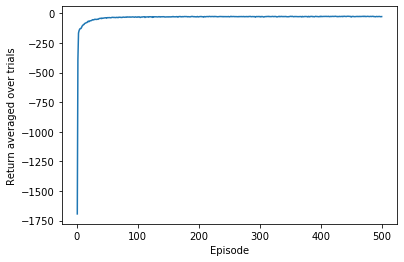

In [9]:
sarsa_agent = SARSA_Agent(alpha=0.5, gamma=1, epsilon=0.1, env=env)
trials = 1000
episodes = 500
returns_episodes = []
for trial in tqdm(range(trials)):
    returns = sarsa_agent.play(env, episodes = episodes)
    returns_episodes.append(returns)
    sarsa_agent.reset(env)
    
returns_episodes = np.array(returns_episodes)
returns_episodes = np.mean(returns_episodes, axis = 0)

t = np.arange(1, episodes + 1)
plt.plot(t, returns_episodes)
plt.xlabel("Episode")
plt.ylabel("Return averaged over trials")
plt.show()

**Optimal Policy learnt by SARSA**

In [14]:
sarsa_agent = SARSA_Agent(alpha=0.5, gamma=1, epsilon=0.1, env=env)
_ = sarsa_agent.play(env, episodes = 500)
sarsa_agent.plot_optimal_policy(env)

R	R	R	R	R	R	R	R	R	R	R	D
U	R	R	U	U	R	R	U	U	R	D	D
U	R	U	U	U	L	U	U	L	L	R	D
U(S)	C	C	C	C	C	C	C	C	C	C	G


We can see here clearly that SARSA learns a conservative policy. Since, the policy is epsilon greedy, the agent will sometimes pick a non optimal action and that may lead to a cliff state incurring a heavy negative reward. So, the SARSA agent learns a policy that keeps the agent as far as possible to the cliff states. It tries to force the agent from (4,1) to the states along (1,j) where j is from 1 to 12. Finally, from (1,12) it starts coming down towards the goal state. So, although it does not learn the optimal shortest path but it learns a safer path where there is very low chance of getting the heavy -100 reward. 

It learns the path:
(4,1) -> (3,1) -> (2,1) -> (1,1) -> (1,2) -> (1,3) -> ..... -> (1,12) -> (2,12) -> (3,12) ->(4,12)

In [15]:
#building the Q learning Agent
class Q_Agent:
    def __init__(self, alpha, gamma, epsilon, env):
        #initializing the parameters of the agent
        self.actions = ['L','R','U','D'] #possible actions
        self.gamma = gamma #discount parameter
        self.Q = self.initialize_value_states(env)
        self.alpha = alpha
        self.epsilon = epsilon
        
    def initialize_value_states(self, env):
        #function to initialize the value of the state action pairs
        q_s = {}
        for state in env.states:
            q_s[state] = {}
            for action in self.actions:
                q_s[state][action] = 0
        return q_s

    def find_a_stars(self, s):
        best_q_val = -np.inf
        greedy_actions = []
        
        for a in self.actions:
            if self.Q[s][a] > best_q_val:
                best_q_val = self.Q[s][a]
                greedy_actions = [a]
            elif self.Q[s][a] == best_q_val:
                greedy_actions.append(a)
                
        return greedy_actions
    
    def reset(self, env):
        self.Q = self.initialize_value_states(env)
        
    def choose_eps_greedy_action(self, s):
        best_values = []
        p = random.random()
        
        if p<=self.epsilon:
            #choose a random action
            a = np.random.choice(self.actions)
        else:
            #choose greedy action based on Q values
            a_stars = self.find_a_stars(s)
            if (len(a_stars)==1): #one best action
                a = a_stars[0]
            else: #multiple optimal action. choose one randomly among them.
                a = np.random.choice(a_stars)
                
        return a
            
    def Q_update(self, env, start_state = (4,1)):
        #function for SARSA on policy update of q values for an episode
        s = start_state
        rewards = 0
        
        while s!= env.terminal_state:
            #choose a using epsilon greedy policy using Q values 
            a = self.choose_eps_greedy_action(s)
            s1, r = env.get_new_state(s,a)
            
        
            rewards+=r
            
            
            a_stars = self.find_a_stars(s1)
            a_star = a_stars[0]
            
            delta_t = (r + (self.gamma*self.Q[s1][a_star])) - self.Q[s][a]
            self.Q[s][a] = self.Q[s][a] + (self.alpha*delta_t)
            
            s = s1
            
            
        return rewards
        
    def play(self, env, episodes = 200):
        returns = []
        for episode_no in range(episodes):
            G = self.Q_update(env)
            returns.append(G)
            #decay epsilon 
            #self.epsilon = self.initial_epsilon/np.sqrt((episode_no+1))
        
        return returns
        
    def plot_optimal_policy(self, env):
        M,N = env.grid_shape
        optimal_moves = []
        for i in range(M):
            row = []
            for j in range(N):
                s = (i+1, j+1)
                if s==env.start_state:
                    value = "(S)"
                    move = self.find_a_stars(s)
                    value = ','.join(move) + value
                    #print (value, end = "\t")
                    row.append(value)
                elif s==env.terminal_state:
                    value = "G"
                    #print (value, end = "  ")
                    row.append(value)
                elif s not in env.holes:
                    #value=str(s)
                    move = self.find_a_stars(s)
                    #value = value + ": " + ','.join(move)
                    value = ','.join(move)
                    #print (value, end = "\t\t")
                    row.append(value)
                else:
                    value = "C" 
                    #print (value, end = "\t")
                    row.append(value)
                    
            optimal_moves.append(row)
            
        for row in optimal_moves:
            print ('\t'.join(row))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:30<00:00, 11.02it/s]


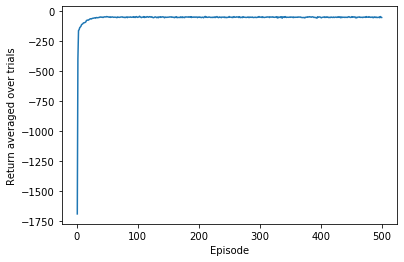

In [16]:
q_agent = Q_Agent(alpha=0.5, gamma=1, epsilon=0.1, env=env)
trials = 1000
episodes = 500
returns_episodes_q = []
for trial in tqdm(range(trials)):
    returns = q_agent.play(env, episodes = episodes)
    returns_episodes_q.append(returns)
    q_agent.reset(env)
    
returns_episodes_q = np.array(returns_episodes_q)
returns_episodes_q = np.mean(returns_episodes_q, axis = 0)

t = np.arange(1, episodes + 1)
plt.plot(t, returns_episodes_q)
plt.xlabel("Episode")
plt.ylabel("Return averaged over trials")
plt.show()

**Optimal Policy learnt by Q-Learning**

In [18]:
q_agent = Q_Agent(alpha=0.5, gamma=1, epsilon=0.1, env=env)
q_agent.play(env, episodes = 500)
q_agent.plot_optimal_policy(env)

R	D	R	R	R	R	R	R	R	R	R	D
U	D	R	R	R	R	D	R	D	R	R	D
R	R	R	R	R	R	R	R	R	R	R	D
U(S)	C	C	C	C	C	C	C	C	C	C	G


Here, we can clearly see that Q-Learning learns the optimal policy itself in spite of the fact that actions will be selected in a epsilon greedy fashion. It learns to reach the goal state in the shortest path from 
(4,1) -> (3,1) -> (3,2) -> ....  -> (3,12) -> (4,12).  

**Comparison of learning curves for SARSA and Q-Learning**

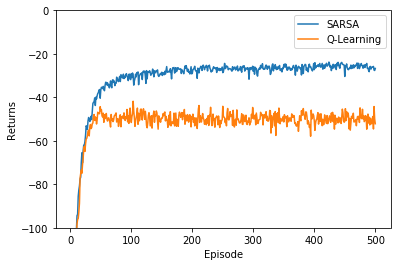

In [19]:
ts = np.arange(1, 501)
plt.plot(ts, returns_episodes, label = "SARSA")
plt.plot(ts, returns_episodes_q, label = "Q-Learning")
plt.xlabel("Episode")
plt.ylabel("Returns")
plt.ylim(-100,0)
plt.legend()
plt.show()

As we can see from the learning curve, SARSA yields a better cumulative reward than Q-learning. This is due to the policies learnt by the two different algorithms. SARSA learns a more conservative policy, traversing a longer path ensuring that the heavy negative reward is not incurred while Q-Learning learns the optimal shortest path but due to the randomess of action selection, will sometime incur the heavier negative reward bringing down its average return.